In [330]:
# Portfolio Markowitz Mean Variance Optimisation

# Modern portfolio theory is a theory on how risk-averse investors can construct portfolios to
# maximise expected return based on a given level of market risk

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas_datareader as pdr
from scipy.optimize import Bounds, minimize

## Collecting Data

We will use the following below ETFs for our portfolio, including the a risk free rate of the 3 month treasury bill.

* SPY - SPDR S&P 500 ETF Trust
* TLT - iShares 20+ Year Treasury Bond ETF
* AAPL - Apple Inc.
* MSFT - Microsoft Corporation
* GOOGL - Alphabet Inc.
* XOM - Exxon Mobil Corporation
* BTC-USD - Bitcoin
* USO - United States Oil Fund LP
* XLK - Technology Select Sector SPDR Fund
* SLV - iShares Silver Trust


In [331]:

def asset_Data(tickers: list, start: str, end: str):
    asset_data = yf.download(tickers, start=start, end=end)
    asset_data = pd.DataFrame(asset_data['Adj Close'])
    asset_data.dropna()
    return asset_data

def fred_Data(series_ids: list, start: str, end: str):
    data = pdr.get_data_fred(series_ids, start=start, end=end)
    if data is not None and not data.empty:
        data.index = pd.to_datetime(data.index)
        return data
    else:
        print('No Data Available')
        return pd.DataFrame()

start = '2016-08-10'
end = '2019-08-10'
# Assets of choice for this portfolio will be ETFs
tickers = ['SPY', 'TLT', 'AAPL', 'MSFT', 'GOOGL', 'XOM', 'BTC-USD', 'USO', 'SLV']
#tickers = ['TLT', 'XLV', 'XLP', 'VNQ', 'DBC', 'XLF', 'XLI', 'XLK', 'EFA'] # another example

# risk-free rates
series_ids = {
    '3MO': 'DGS3MO', # 3-Month Treasury Bill
    '1YR': 'DGS1', # 1-Year Treasury Constant Maturity Rate
    '5YR': 'DGS5', # 5-Year Treasury Constant Maturity Rate
    '10YR': 'DGS10', # 10- Year Treasury Constant Maturity Rate
    }

# Gather the data
fed_data = pd.DataFrame({name: fred_Data(series_id, start, end)[series_id]
                         for name, series_id in series_ids.items()})

asset_data = asset_Data(tickers, start, end)
#fed_data.ffill(inplace=True)

print("\n", asset_data.head())
print(fed_data.head())

[*********************100%***********************]  9 of 9 completed



 Ticker                          AAPL     BTC-USD      GOOGL       MSFT  \
Date                                                                     
2016-08-10 00:00:00+00:00  24.904648  592.103027  40.324650  52.009552   
2016-08-11 00:00:00+00:00  24.888508  589.119995  40.310184  52.260555   
2016-08-12 00:00:00+00:00  24.946161  587.559021  40.252827  51.937855   
2016-08-13 00:00:00+00:00        NaN  585.588013        NaN        NaN   
2016-08-14 00:00:00+00:00        NaN  570.473022        NaN        NaN   

Ticker                           SLV         SPY         TLT        USO  \
Date                                                                      
2016-08-10 00:00:00+00:00  19.160000  189.197067  114.497475  78.160004   
2016-08-11 00:00:00+00:00  18.959999  190.075089  113.476334  81.680000   
2016-08-12 00:00:00+00:00  18.719999  189.909927  114.432114  84.000000   
2016-08-13 00:00:00+00:00        NaN         NaN         NaN        NaN   
2016-08-14 00:00:00+00:00    

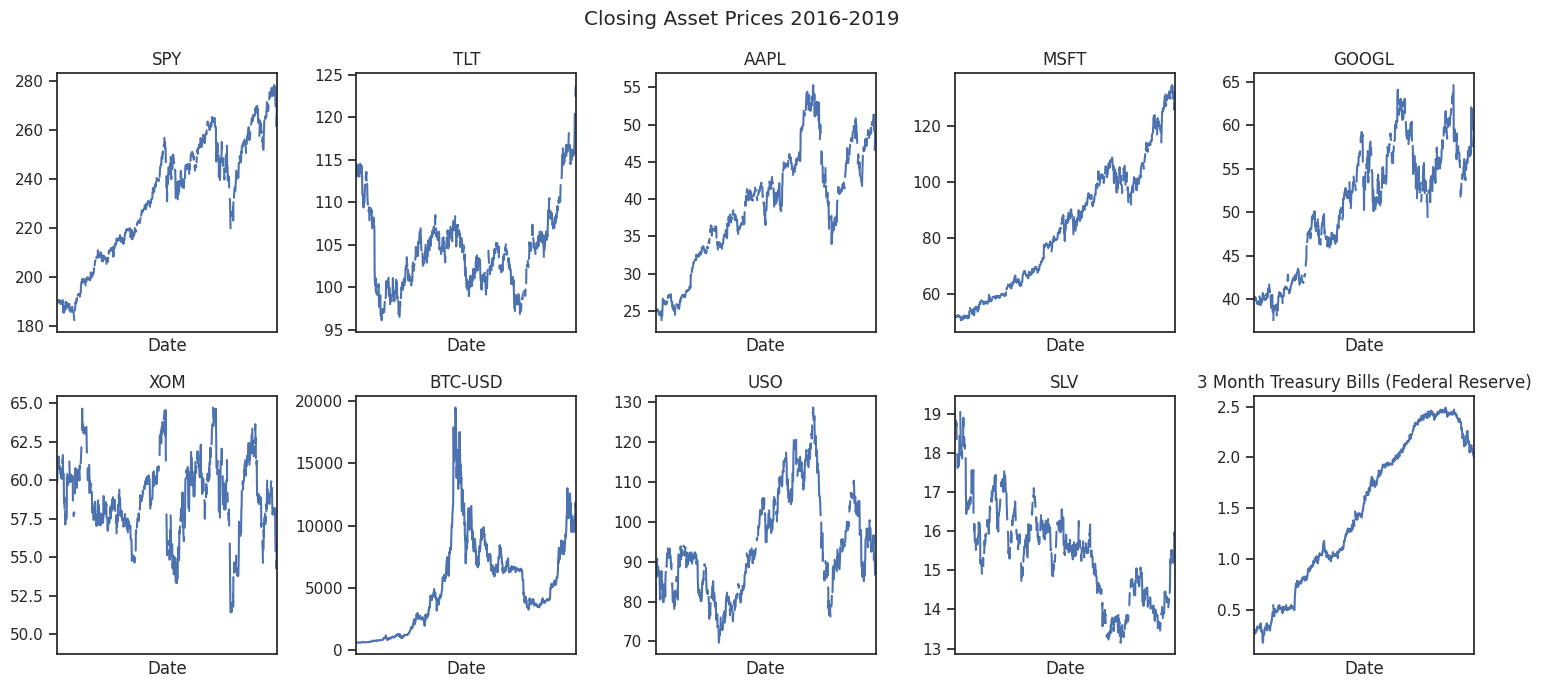

In [332]:
# Plot of the historical prices of the assets and risk-free asset
fig, axes = plt.subplots(2, 5, figsize=(15,7))
axes = axes.flatten()

for i, ticker in enumerate(tickers):
    asset_data[ticker].plot(ax=axes[i], title=f'{ticker}')
    axes[i].set_xlabel('Date')
    axes[i].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

fed_data['3MO'].plot(ax=axes[-1], title='3 Month Treasury Bills (Federal Reserve)')
axes[-1].set_xlabel('Date')
axes[-1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
fig.suptitle('Closing Asset Prices 2016-2019')
plt.tight_layout()
plt.show()

## Calculate the returns on the Assets and risk-free asset

<ipython-input-333-a59d2f7955e8>:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  portfolio = portfolio.pct_change().ffill().dropna()


                                 SPY         TLT       AAPL       MSFT  \
Date                                                                     
2016-08-10 00:00:00+00:00  24.904648  592.103027  40.324650  52.009552   
2016-08-11 00:00:00+00:00  24.888508  589.119995  40.310184  52.260555   
2016-08-12 00:00:00+00:00  24.946161  587.559021  40.252827  51.937855   
2016-08-13 00:00:00+00:00        NaN  585.588013        NaN        NaN   
2016-08-14 00:00:00+00:00        NaN  570.473022        NaN        NaN   

                               GOOGL         XOM     BTC-USD        USO  \
Date                                                                      
2016-08-10 00:00:00+00:00  19.160000  189.197067  114.497475  78.160004   
2016-08-11 00:00:00+00:00  18.959999  190.075089  113.476334  81.680000   
2016-08-12 00:00:00+00:00  18.719999  189.909927  114.432114  84.000000   
2016-08-13 00:00:00+00:00        NaN         NaN         NaN        NaN   
2016-08-14 00:00:00+00:00      

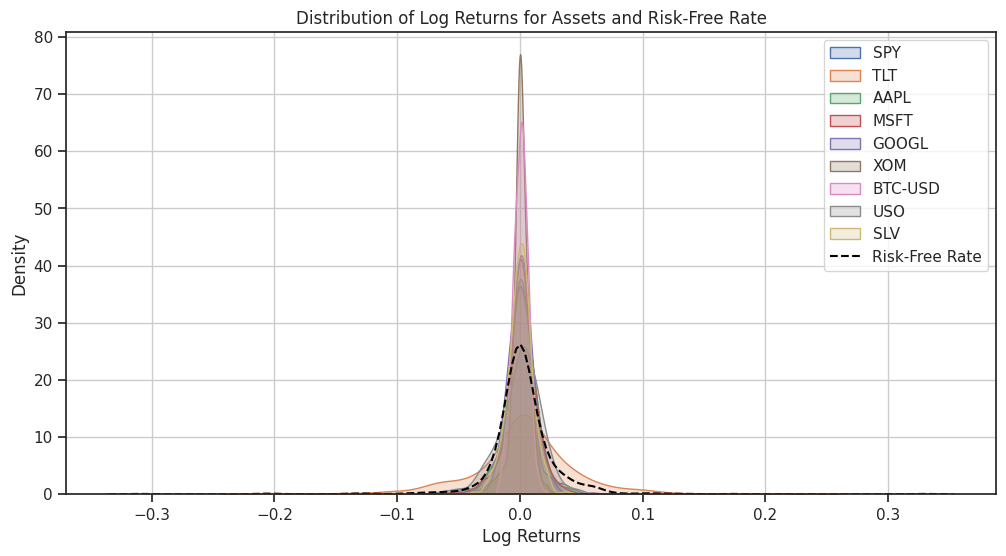

In [333]:
def log_returns(portfolio):
    '''Daily Log Returns'''
    # Calculate the returns of the
    portfolio = portfolio.pct_change().ffill().dropna()
    return np.log(1 + portfolio)

# Calculate the returns of the assets and risk free asset
asset_data.columns = tickers
asset_log_returns =log_returns(asset_data)

# risk free rate (here we will use 3 month Treasury bills)

# Data Diagnostics
# Remove timezone info from the assets
asset_log_returns.index = asset_log_returns.index.tz_localize(None)
rf_rate.index = rf_rate.index.tz_localize(None)
aligned_data = asset_log_returns.join(rf_rate, how='inner')  # remove holiday data from the treasury bill and any other day where the ETFs weren't trading

asset_log_returns = aligned_data.iloc[:, :-1]
rf_rate = aligned_data.iloc[:, -1]

print(asset_data.head())
print(rf_rate.head())

## Plot the KDE distribution for all assets
# This helps us visualise whether log returns follow any distribution and identify skewness
plt.figure(figsize=(12,6))

for asset in asset_data.columns:
  sns.kdeplot(asset_log_returns[asset], label=asset, fill=True)

sns.kdeplot(rf_rate, label='Risk-Free Rate', color='black', linestyle='--')
plt.title("Distribution of Log Returns for Assets and Risk-Free Rate")
plt.xlabel("Log Returns")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

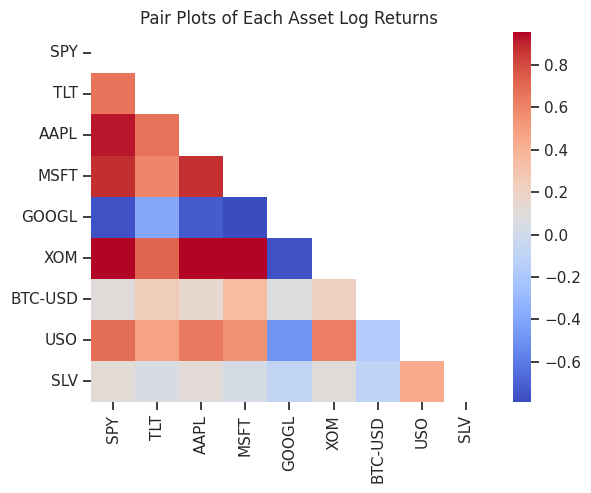

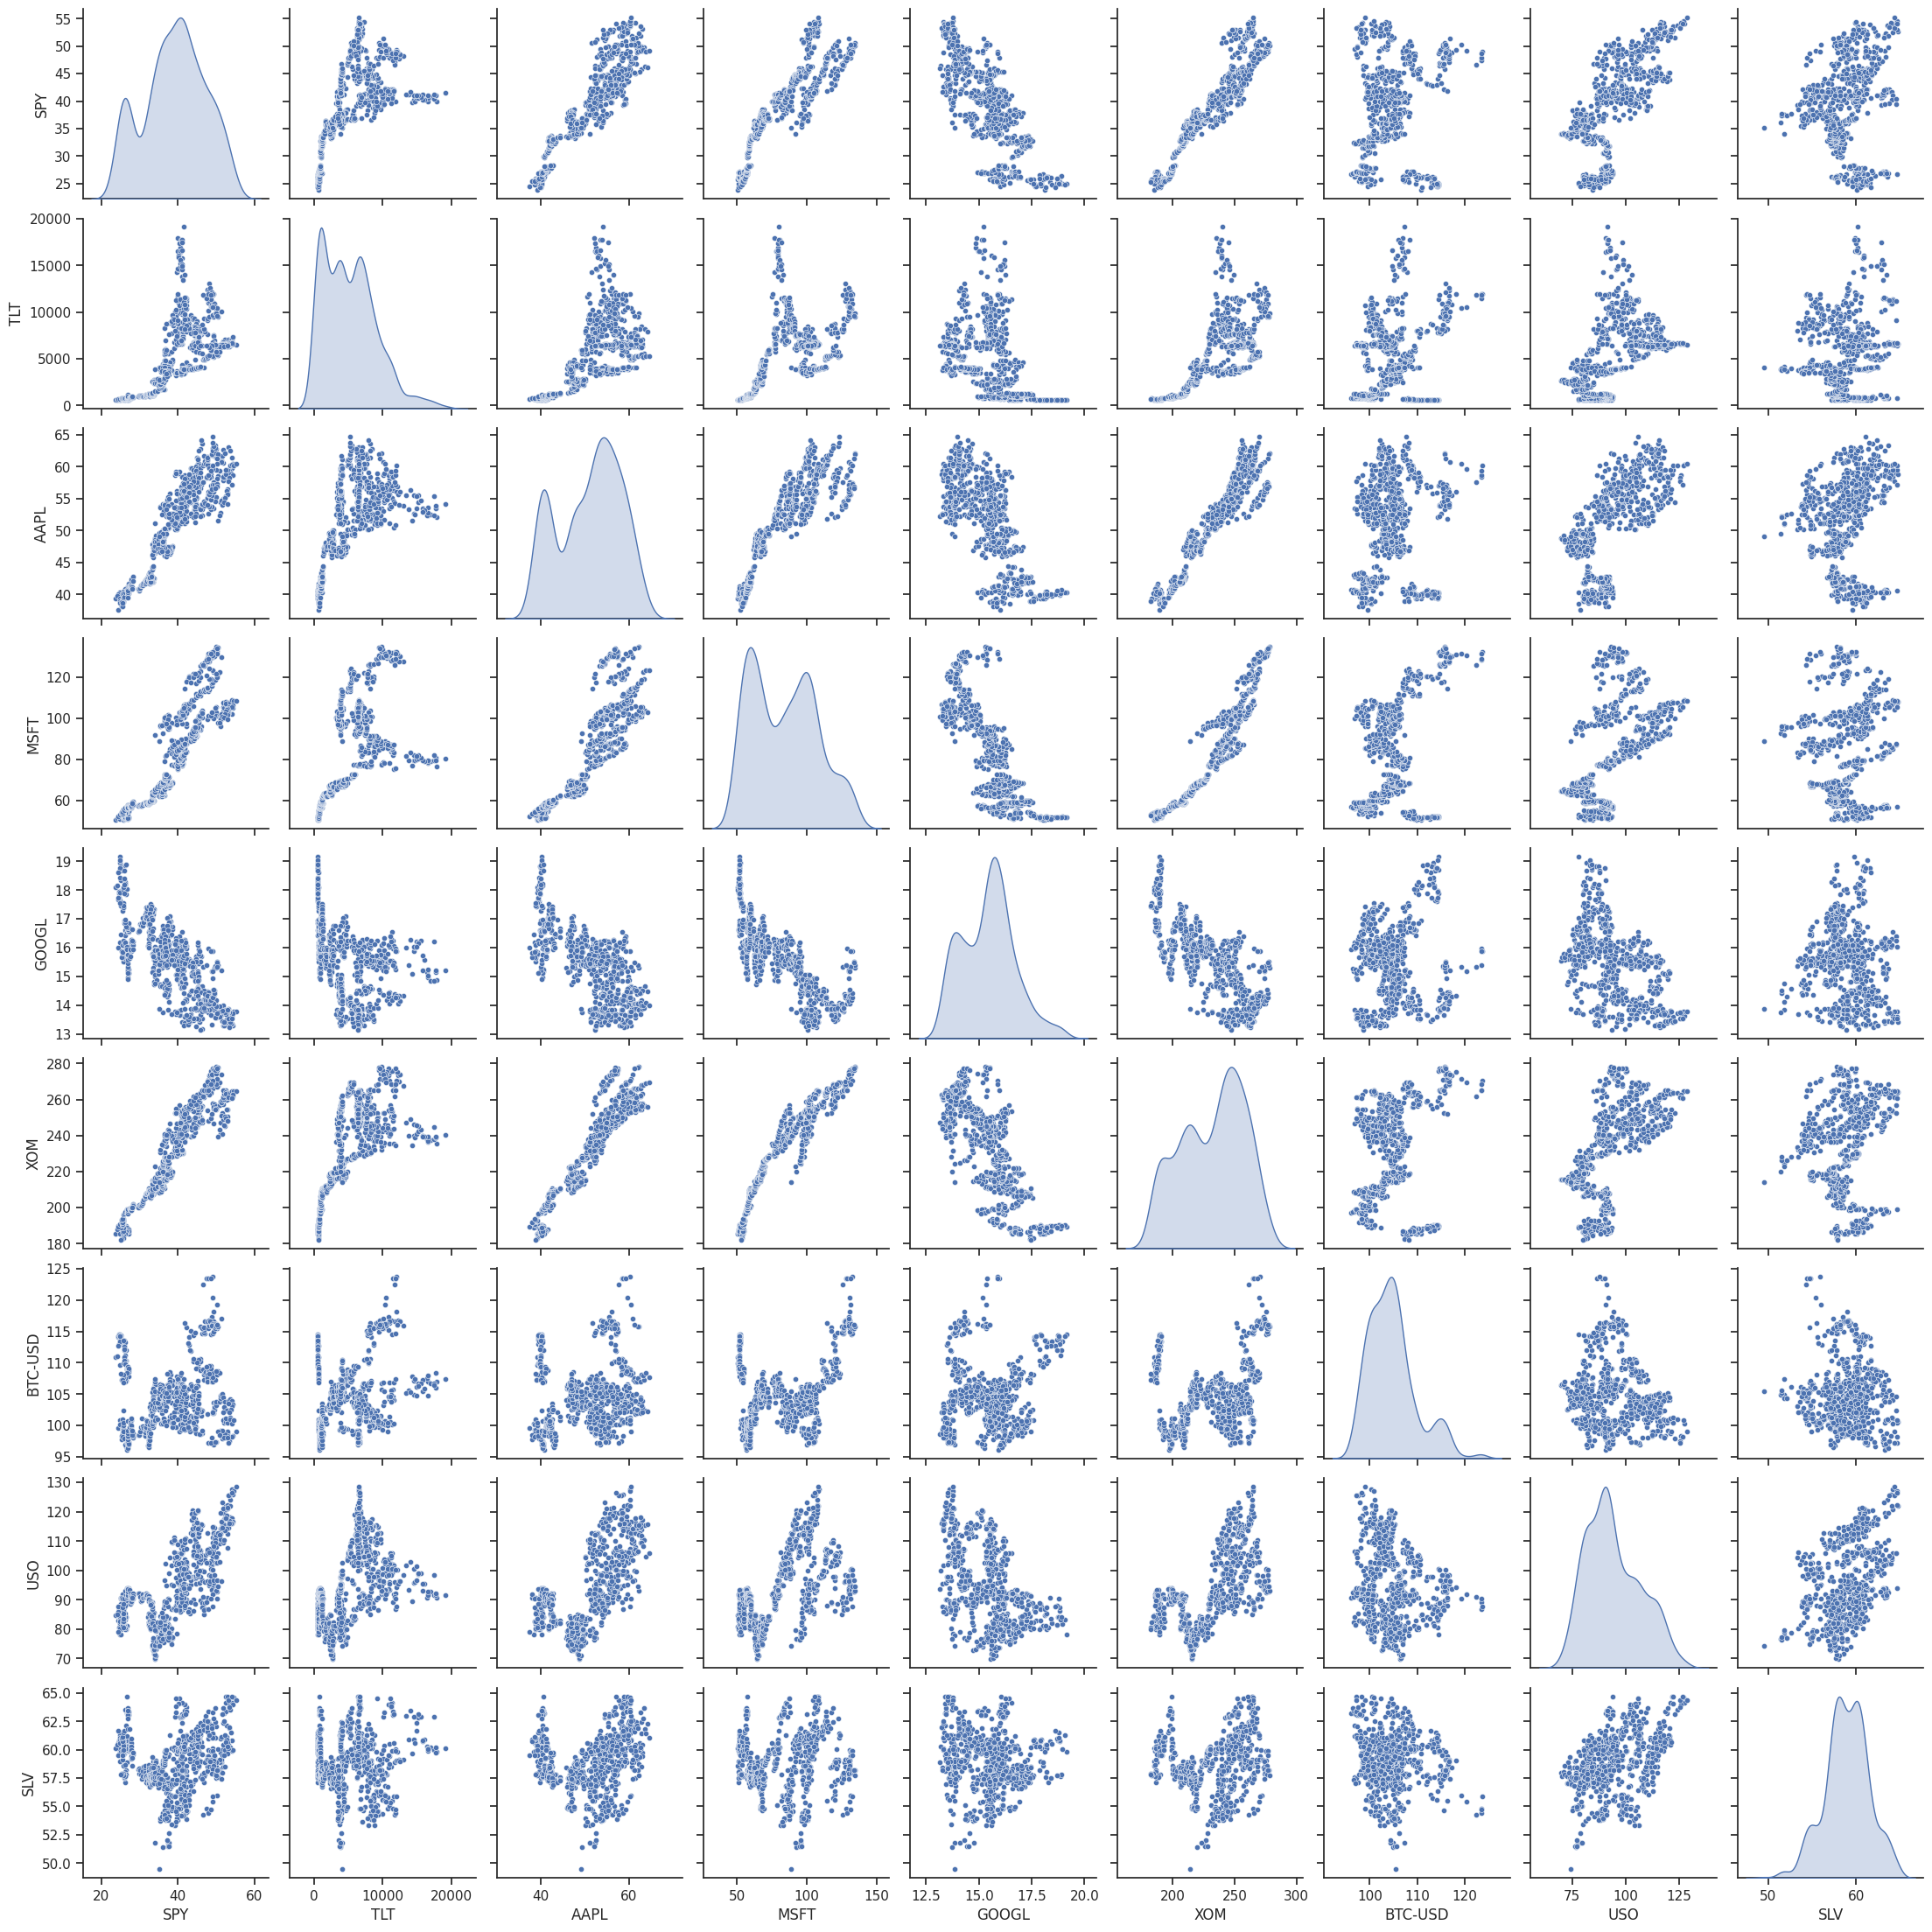

In [334]:
asset_corr = asset_data.corr()
mask = np.zeros_like(asset_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(asset_corr, cmap='coolwarm', mask=mask)
plt.title("Pair Plots of Each Asset Log Returns")
plt.show()

sns.set(font_scale=1)
sns.set(style='ticks', color_codes=True)
sns.pairplot(data=asset_data, vars=asset_data.columns, diag_kind='kde',
              kind='scatter', plot_kws={'s':20})
plt.show()

Create the Portfolio Weights which will represent our exposure to each asset in our portfolio. In this example, we are only looking at long-trade only portfolio thta is full invested always, meaning the weights will be bounded between 0 and 1, and the weights sum to 1. We will run an additional parameter being the number of simulations we want to run, this will create sims number of columns in our weight matrix.

In [335]:
def portfolio_Weights(num_portfolios: int, num_assets: int):
    ''' Randomly generate the weights that sum to 1 using Dirichlet'''
    return np.random.dirichlet(np.ones(num_assets), num_portfolios)


sims = 100_000 # Number of Monte Carlo Simulations

# Calculate the weights
weights = portfolio_Weights(sims, len(tickers))

print(weights.shape)

(100000, 9)


## Calculate the Mean Variance of the portfolios

The equations and explanations for the mathematics here is presented on the paper written alongside this.

In [336]:
def portfolio_Reward(weights, exp_returns):
    return np.dot(weights.T, exp_returns)

def portfolio_Variance(weights, sigma):
    return weights.T.dot(sigma).dot(weights)

def performance(weights, portfolios, rf_rate, alpha, sigma):

    portfolio_returns = [0] * portfolios # portfolios is the number of simulations
    portfolio_variance = [0] * portfolios
    portfolio_volatility = [0] * portfolios
    portfolio_sharpe = [0] * portfolios
    rf_rate_mean = rf_rate.mean()

    for i in range(portfolios):
        w = weights[i]
        portfolio_returns[i] = portfolio_Reward(w, alpha)
        portfolio_variance[i] = portfolio_Variance(w, sigma)
        portfolio_volatility[i] = np.sqrt(portfolio_variance[i])
        portfolio_sharpe[i] = (portfolio_returns[i] - rf_rate_mean)/portfolio_volatility[i]


    return portfolio_returns, portfolio_variance, portfolio_volatility, portfolio_sharpe


# Calculate the alpha (expected returns) and sigma (returns covariance) adjusted annually
alpha, sigma = asset_log_returns.mean() * 252, asset_log_returns.cov() * 252


portfolio_returns, portfolio_variance, portfolio_volatility, portfolio_sharpe = performance(weights,
                                                                                            sims,
                                                                                            rf_rate,
                                                                                            alpha,
                                                                                            sigma)

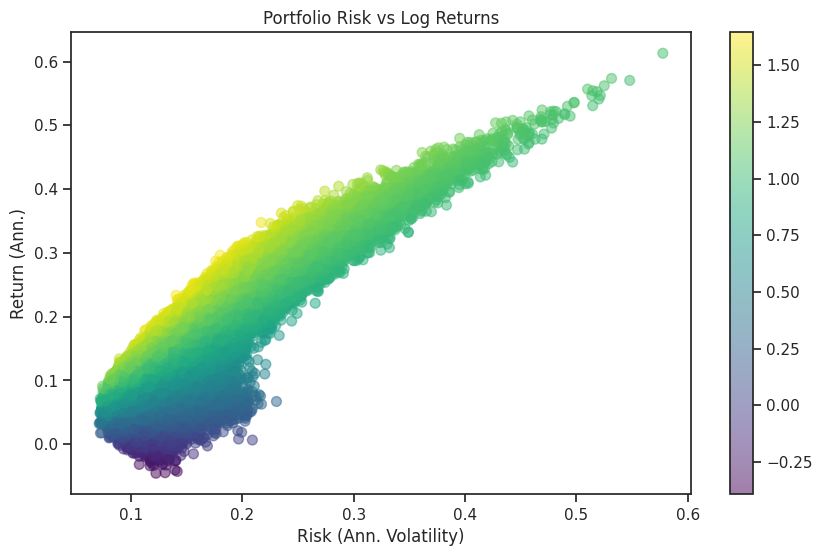

In [337]:
def feasible_Set(portfolio_returns, portfolio_volatility, portfolio_sharpe):
    plt.figure(figsize=(10,6))
    plt.scatter(portfolio_volatility, portfolio_returns, alpha=0.5, s=50, c=portfolio_sharpe, cmap='viridis', marker='o')
    plt.colorbar()
    plt.title("Portfolio Risk vs Log Returns")
    plt.xlabel("Risk (Ann. Volatility)")
    plt.ylabel("Return (Ann.)")
    plt.show()

# Scatter plot of Risk/Reward of all simulations
feasible_Set(portfolio_returns, portfolio_volatility, portfolio_sharpe)

## Efficient Frontier Curve

The Efficient Frontier is the of optimial portfolios that offer the highest expected return for a defined level of risk. It can also be defined as: the optimial portfolios that offer the lowest level of risk for a defined level of returns. Here we have plotted it as a black line.

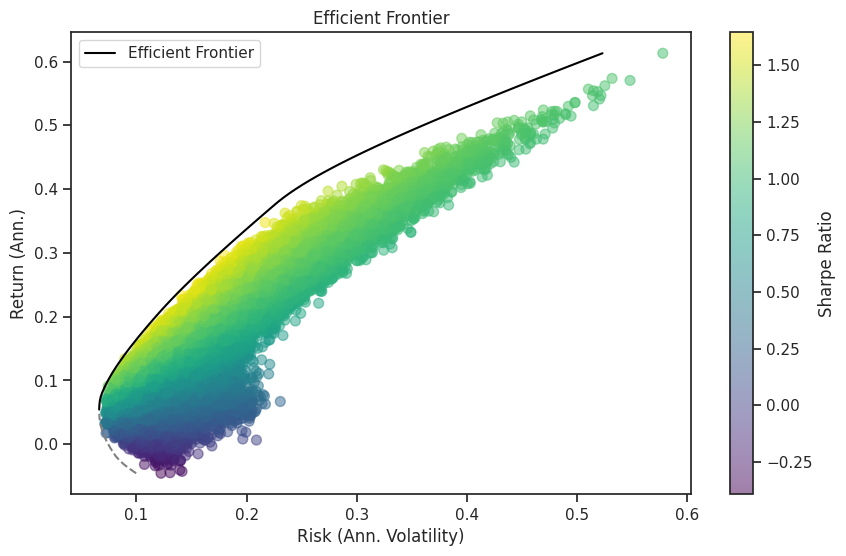

In [338]:
def efficient_Frontier(portfolio_returns, portfolio_volatility, portfolio_sharpe,
                 tickers, alpha, sigma):
    '''
    We will not take into account borrowing (weights outside [0, 1]), i.e. we are long-only,
    fully invested portfolio. As a result, the best method to optimise the risk/return is to
    use SLSQP, a gradient-based optimisation algorithm, as it is efficient for smooth objective
    functions with constraints. Additionally, SLSQP is best because it handles nonlinear
    optimisations well.
    '''
    results_volatility = []
    results_weights = []
    target_returns = np.linspace(min(portfolio_returns), max(portfolio_returns), 100)
    bounds = Bounds(0, 1) # no short-selling, only long-trades
    initial_return = [1 / len(tickers)]*len(tickers)

    for target_return in target_returns:
        # constraints we want to minimise for the SLSQP
        constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
                       {'type': 'eq', 'fun': lambda weights: portfolio_Reward(weights, alpha) - target_return})

        efficient_results = minimize(portfolio_Variance, initial_return, method='SLSQP',
                           args=(sigma,), bounds=bounds, constraints=constraints)

        volatility = np.sqrt(efficient_results.fun)
        weights = efficient_results.x

        results_volatility.append(volatility)
        results_weights.append(weights)


    min_volatility_index = np.argmin(results_volatility)

    efficient_volatility = results_volatility[min_volatility_index:]
    efficient_returns = target_returns[min_volatility_index:]
    optimal_weights = results_weights[min_volatility_index:]

    inefficient_volatility = results_volatility[:min_volatility_index]
    inefficient_returns = target_returns[:min_volatility_index]

    # Efficient Frontier plot
    plt.figure(figsize=(10,6))
    plt.scatter(portfolio_volatility, portfolio_returns, alpha=0.5, s=50, c=portfolio_sharpe, cmap='viridis', marker='o')

    # Efficient Frontier Curve
    plt.plot(efficient_volatility, efficient_returns, color='black', label='Efficient Frontier')

    # Inefficient Frontier Curve
    plt.plot(inefficient_volatility, inefficient_returns, color='grey', linestyle='--')

    plt.colorbar(label='Sharpe Ratio')
    plt.title("Efficient Frontier")
    plt.xlabel("Risk (Ann. Volatility)")
    plt.ylabel("Return (Ann.)")
    plt.legend()
    plt.show()

    return efficient_volatility, efficient_returns, optimal_weights

# Calculates the Efficient Frontier points
optimal_volatility, optimal_returns, optimal_weights = efficient_Frontier(portfolio_returns, portfolio_volatility,
                   portfolio_sharpe,tickers, alpha, sigma)

In [339]:
print(f'Highest Returns with the lowest risk of {round(min(optimal_volatility), 4)}, is {round(optimal_returns[np.argmin(optimal_volatility)], 4)}')

Highest Returns with the lowest risk of 0.0662, is 0.0543


# Mean-Variance Optimisation with Risk Free Asset

Now we will consider the inclusion of a risk free asset in the portfolio. For this example, we will continue to use the 3 month treasury bill, as well as the same ETFs.

To begin, we need to recalculate the portfolio return and variance:

In [340]:
def portfolio_Returns_rf(weights, exp_returns, r0):
    risky_weights = weights[:-1]
    risk_free_weights = weights[-1]
    #print(risky_weights.shape, risk_free_weights.shape)
    return np.dot(risky_weights, exp_returns) + risk_free_weights*r0

def portfolio_Variance_rf(weights, sigma):
    risky_weights = weights[:-1]
    return risky_weights.T.dot(sigma).dot(risky_weights)

def performance_rf(weights, portfolios, rf_rate, alpha, sigma, r0):
    ''' including the risk free asset as a possible investment '''
    portfolio_returns = [0] * portfolios # portfolios is the number of simulations
    portfolio_variance = [0] * portfolios
    portfolio_volatility = [0] * portfolios
    portfolio_sharpe = [0] * portfolios
    rf_rate_mean = rf_rate.mean()

    for i in range(portfolios):
        w = weights[i]
        portfolio_returns[i] = portfolio_Returns_rf(w, alpha, r0)
        portfolio_variance[i] = portfolio_Variance_rf(w, sigma)
        portfolio_volatility[i] = np.sqrt(portfolio_variance[i])
        portfolio_sharpe[i] = (portfolio_returns[i] - rf_rate_mean)/portfolio_volatility[i]


    return portfolio_returns, portfolio_variance, portfolio_volatility, portfolio_sharpe

In [341]:
# risk free rate (here we will use 3 month Treasury bills)
# rf_rate = log_returns(fed_data['3MO']) defined earlier

r0 = rf_rate.mean() # we will model the average (constant) rate over the time period

# Calculate the weights
weights_rf = portfolio_Weights(sims, len(tickers)+1) # + 1 for the risk-free asset

portfolio_returns_rf, portfolio_variance_rf, portfolio_volatility_rf, portfolio_sharpe_rf = performance_rf(weights_rf,
                                                                                              sims,
                                                                                              rf_rate,
                                                                                              alpha,
                                                                                              sigma,
                                                                                              r0)

### The Feasible Set:

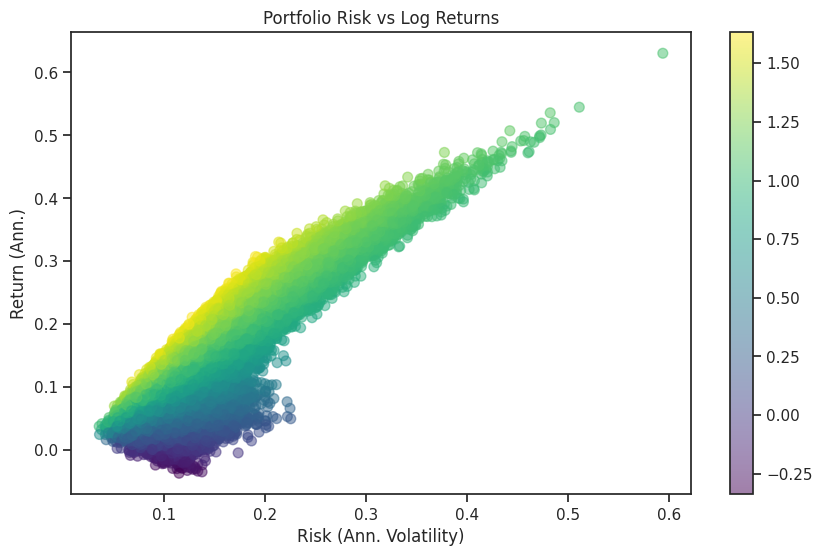

In [342]:
# Scatter plot of Risk/Reward of all simulations
feasible_Set(portfolio_returns_rf, portfolio_volatility_rf, portfolio_sharpe_rf)

## Efficient Frontier including risk-free assets (CML line)

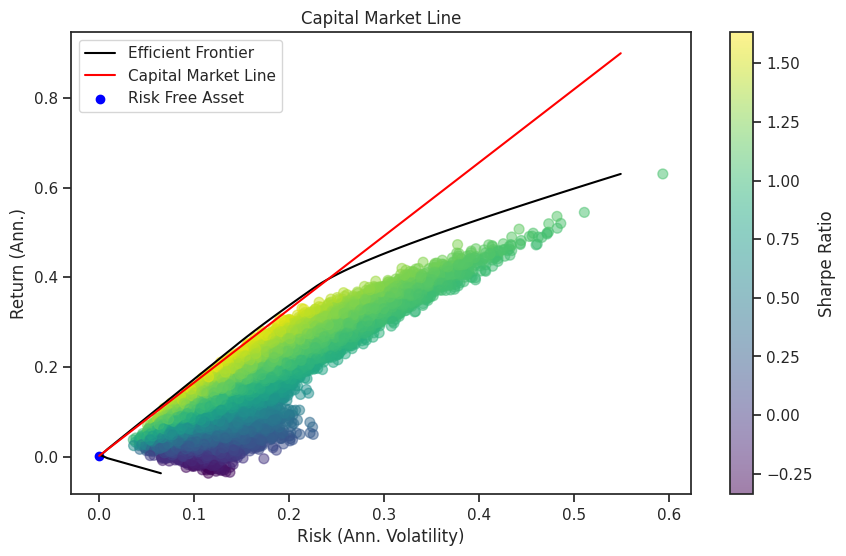

In [343]:
def Capital_Market_Line(portfolio_returns, portfolio_volatility, portfolio_sharpe,
                 tickers, alpha, sigma, r0):
    '''
    We will not take into account borrowing (weights outside [0, 1]), i.e. we are long-only,
    fully invested portfolio. As a result, the best method to optimise the risk/return is to
    use SLSQP, a gradient-based optimisation algorithm, as it is efficient for smooth objective
    functions with constraints. Additionally, SLSQP is best because it handles nonlinear
    optimisations well.
    '''
    optimal_volatility = []
    optimal_weights = []
    target_returns = np.linspace(min(portfolio_returns), max(portfolio_returns), 100)
    bounds = Bounds(0, 1) # no short-selling, only long-trades
    initial_return = [1 / (len(tickers))]*(len(tickers))

    for target_return in target_returns:
        # constraints we want to minimise for the SLSQP
        constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
                       {'type': 'eq', 'fun': lambda weights: portfolio_Returns_rf(weights, alpha, r0) - target_return})

        efficient_results = minimize(portfolio_Variance_rf, initial_return + [0], method='SLSQP',
                           args=(sigma,), bounds=bounds, constraints=constraints)

        volatility = np.sqrt(efficient_results.fun)#np.sqrt(portfolio_Variance(efficient_results.x, sigma))
        weights = efficient_results.x#portfolio_Reward(efficient_results.x, alpha)

        optimal_volatility.append(volatility)
        optimal_weights.append(weights)


    # Efficient Frontier plot
    plt.figure(figsize=(10,6))
    plt.scatter(portfolio_volatility, portfolio_returns, alpha=0.5, s=50, c=portfolio_sharpe, cmap='viridis', marker='o')

    # Efficient Frontier Curve
    plt.plot(optimal_volatility, target_returns, color='black', label='Efficient Frontier')
    plt.colorbar(label='Sharpe Ratio')
    # Capital Market Line
    max_sharpe = np.max(portfolio_sharpe)
    cml_x = np.linspace(0, max(optimal_volatility), 100)
    cml_y = r0 + max_sharpe*cml_x
    plt.plot(cml_x, cml_y, color='red', label='Capital Market Line')
    plt.scatter(0, r0, color='blue', label='Risk Free Asset')

    plt.title("Capital Market Line")
    plt.xlabel("Risk (Ann. Volatility)")
    plt.ylabel("Return (Ann.)")
    plt.legend()
    plt.show()

    return optimal_volatility, optimal_weights

# Capital Market Line
optimal_volatility_rf, optimal_weights_rf = Capital_Market_Line(portfolio_returns_rf, portfolio_volatility_rf,
                   portfolio_sharpe_rf,tickers, alpha, sigma, r0)

The difference between the Capital Market Line and the calculated Efficient Frontier with Risk-Free Assets is down to numerical error. We can clearly observe that when we include risk-free assets into the portfolio, we hit a much higher return at a given risk compared to a portfolio only investing in risky assets.

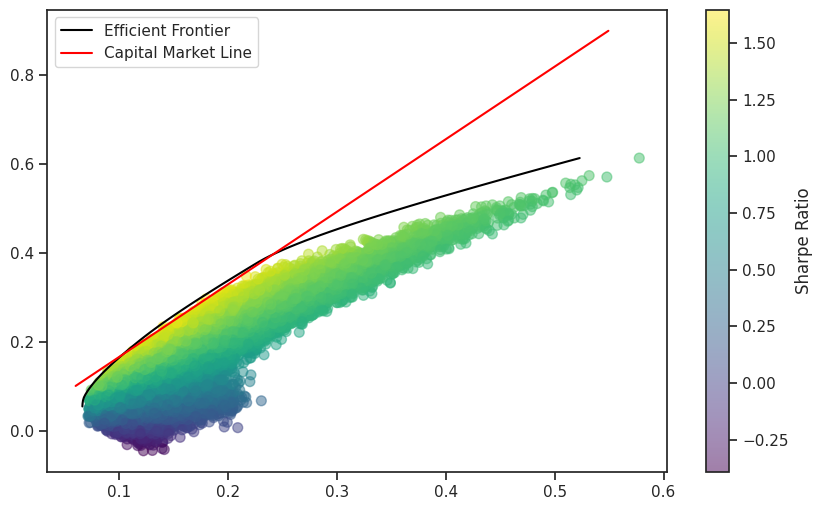

In [344]:
plt.figure(figsize=(10, 6))
# Risky Portfolio Feasible Set
plt.scatter(portfolio_volatility, portfolio_returns, alpha=0.5, s=50, c=portfolio_sharpe, cmap='viridis', marker='o')
plt.colorbar(label="Sharpe Ratio")
# Risky Portfolio Efficient Frontier
plt.plot(optimal_volatility, optimal_returns, color='black', label='Efficient Frontier')

# CML
max_sharpe = np.max(portfolio_sharpe_rf)
cml_x = np.linspace(0.06, max(optimal_volatility_rf), 100)
cml_y = r0 + max_sharpe*cml_x
plt.plot(cml_x, cml_y, color='red', label='Capital Market Line')
plt.legend()
plt.show()

The CML here should be the tangent to the efficient frontier but due to numerical error, it is slightly off.

## Comparing Performances

We can compare the performance of the following portfolios:
* Randomised weighted risky portfolio
* Randomised weighted risky and risk-free portfolio
* Optimal weighted risky portfolio
* Optimal weighted risky and risk-free portfolio.

We will choose the same risky tolerance for all portfolios. This risk tolerance will be randomly chosen from the simulation batch. The portfolios will be assest through 01-01-2016 to 01-01-2019 (pre COVID).

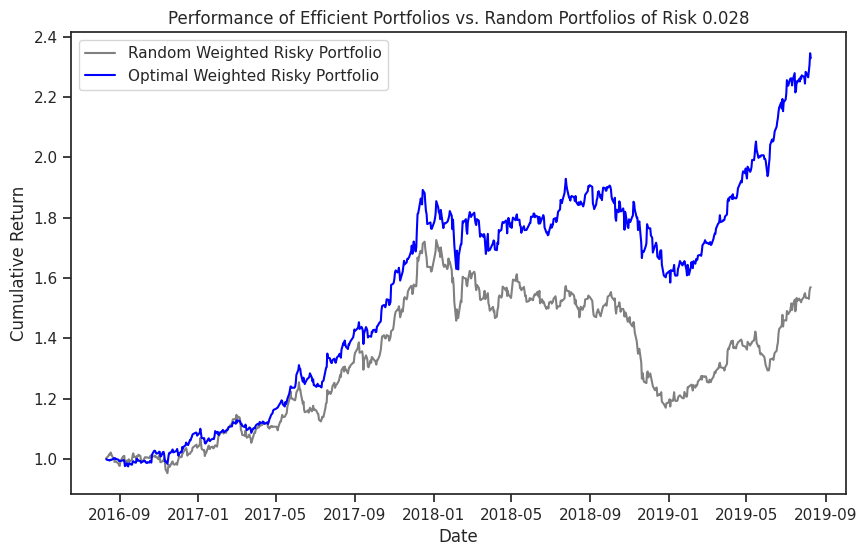

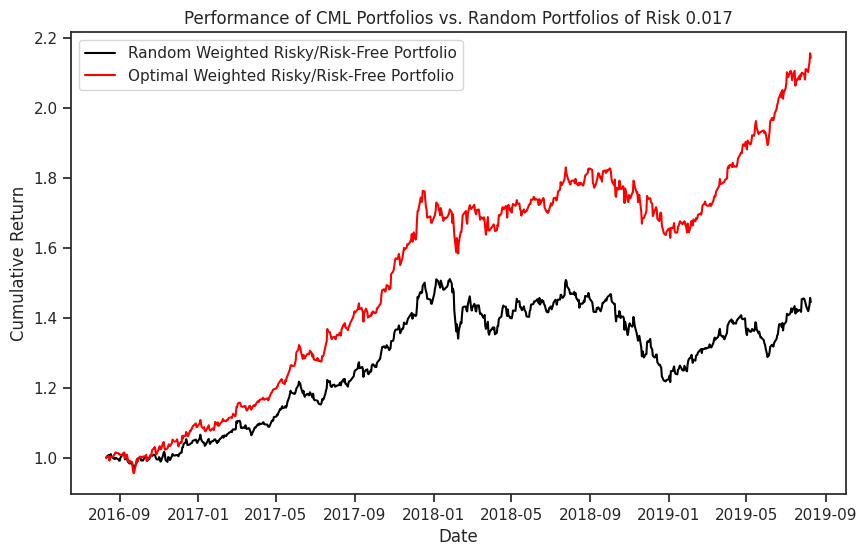

In [347]:
# Pre COVID performance

random_idx = np.random.choice(range(sims))

# Randomised Risky Weighted Portfolio
random_portfolio_weights = weights[random_idx]
random_portfolio_variance = portfolio_variance[random_idx]
random_portfolio_returns = np.dot(asset_log_returns, random_portfolio_weights)
cum_random_portfolio = np.exp(np.cumsum(random_portfolio_returns))

# Randomised Risky & Risk-Free Portfolio
random_portfolio_weights_rf = weights_rf[random_idx]
random_portfolio_variance_rf = portfolio_variance_rf[random_idx]
random_risky_weights = random_portfolio_weights_rf[:-1]
random_risk_free_weight = random_portfolio_weights_rf[-1]
random_risky_returns_rf = np.dot(asset_log_returns, random_risky_weights)
random_portfolio_returns_rf = (1- random_risk_free_weight) * random_risky_returns_rf + random_risk_free_weight * rf_rate
cum_random_portfolio_rf = np.exp(np.cumsum(random_portfolio_returns_rf))

# Optimal Weighted Risky Portfolio
#ef_idx = np.argmin([abs(vol - random_portfolio_variance) for vol in optimal_volatility])
ef_idx = np.argmin([abs(vol**2 - random_portfolio_variance) for vol in optimal_volatility])
optimal_portfolio_weights = np.array(optimal_weights[ef_idx])
optimal_daily_returns = np.dot(asset_log_returns, optimal_portfolio_weights)
cum_optimal_risky_returns = np.exp(np.cumsum(optimal_daily_returns))

# Optimal Weighted Risky & Risk-Free Portfolio
cml_idx = np.argmin([abs(vol**2 - random_portfolio_variance_rf) for vol in optimal_volatility_rf])
risky_rf_portfolio_weights = np.array(optimal_weights_rf[cml_idx])
rf_portfolio_risky_weights = risky_rf_portfolio_weights[:-1]
rf_portfolio_risk_free_weight = risky_rf_portfolio_weights[-1]
rf_portfolio_risky_returns = np.dot(asset_log_returns, rf_portfolio_risky_weights)
portfolio_daily_returns_rf = (1 - rf_portfolio_risk_free_weight) * rf_portfolio_risky_returns + rf_portfolio_risk_free_weight * rf_rate
cum_rf_portfolio_returns = np.exp(np.cumsum(portfolio_daily_returns_rf))


# plot the performance of all portfolios
plt.figure(figsize=(10, 6))
plt.plot(asset_log_returns.index, cum_random_portfolio, color='grey', label='Random Weighted Risky Portfolio')
plt.plot(asset_log_returns.index, cum_optimal_risky_returns, color='blue', label='Optimal Weighted Risky Portfolio')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.title(f'Performance of Efficient Portfolios vs. Random Portfolios of Risk {round(random_portfolio_variance, 3)}')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(asset_log_returns.index, cum_random_portfolio_rf, color='black', label='Random Weighted Risky/Risk-Free Portfolio')
plt.plot(asset_log_returns.index, cum_rf_portfolio_returns, color='red', label='Optimal Weighted Risky/Risk-Free Portfolio')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.title(f'Performance of CML Portfolios vs. Random Portfolios of Risk {round(random_portfolio_variance_rf, 3)}')
plt.legend()
plt.show()

In [346]:
print(random_portfolio_variance, random_portfolio_variance_rf, optimal_volatility[ef_idx]**2, optimal_volatility_rf[cml_idx]**2)

0.01795558417623613 0.009787435117569205 0.018388255556851866 0.009901510918849036
